## Run a Mask RCNN  detectron2 model on Custom Dataset

### 1st Step: Register your  dataset to detectron2

Register your dataset (i.e., tell detectron2 how to obtain your dataset).

In [1]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from matplotlib import pyplot as plt

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("robots_train", {}, "dataset/robot_keypoints_train_fixed.json", "dataset/images")
register_coco_instances("robots_test", {}, "dataset/robot_keypoints_test_fixed.json", "dataset/images")

# register_coco_instances("robots_val", {}, "dataset/robot_keypoints_val.json", "dataset/images")

In [3]:
from detectron2.data import MetadataCatalog

classes = MetadataCatalog.get("robots_train").thing_classes = ["robot"]
print(classes)

['robot']


In [4]:
keypoint_names = ["head","trunk","right_hand","left_hand","right_foot","left_foot"]
keypoint_flip_map = [("head","trunk"), ("trunk","right_hand"), ("trunk","left_hand"),("trunk","right_foot"),("trunk","left_foot")]
keypoint_connection_rules = [("head","trunk", (102, 204, 255)), 
                             ("trunk","right_hand", (128, 229, 255)), 
                             ("trunk","left_hand", (153, 255, 204)),
                             ("trunk","right_foot", (153, 255, 204)),
                             ("trunk","left_foot", (255, 255, 77))]

In [5]:

MetadataCatalog.get("robots_train").thing_classes = ["robot"]
MetadataCatalog.get("robots_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("robots_train").keypoint_names = keypoint_names
MetadataCatalog.get("robots_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("robots_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("robots_train").evaluator_type="coco"


In [6]:
dataset_dicts = DatasetCatalog.get("robots_train")
# dataset_dicts

[11/16 19:39:50 d2.data.datasets.coco]: Loaded 1004 images in COCO format from dataset/robot_keypoints_train_fixed.json


In [7]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

robots_metadata = MetadataCatalog.get("robots_train")

def cv2_imshow(im):
    plt.figure(), plt.imshow(im), plt.axis('off');

In [8]:
robots_metadata

namespace(name='robots_train',
          json_file='dataset/robot_keypoints_train_fixed.json',
          image_root='dataset/images',
          evaluator_type='coco',
          thing_classes=['robot'],
          thing_dataset_id_to_contiguous_id={1: 0},
          keypoint_names=['head',
                          'trunk',
                          'right_hand',
                          'left_hand',
                          'right_foot',
                          'left_foot'],
          keypoint_flip_map=[('head', 'trunk'),
                             ('trunk', 'right_hand'),
                             ('trunk', 'left_hand'),
                             ('trunk', 'right_foot'),
                             ('trunk', 'left_foot')],
          keypoint_connection_rules=[('head', 'trunk', (102, 204, 255)),
                                     ('trunk', 'right_hand', (128, 229, 255)),
                                     ('trunk', 'left_hand', (153, 255, 204)),
                         

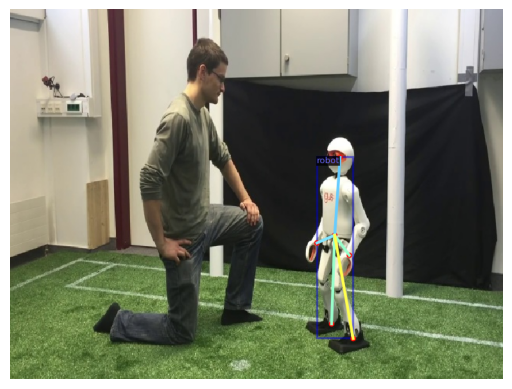

In [9]:
d = dataset_dicts[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=robots_metadata, scale=1.2)   
vis = visualizer.draw_dataset_dict(d)
cv2_imshow(vis.get_image())

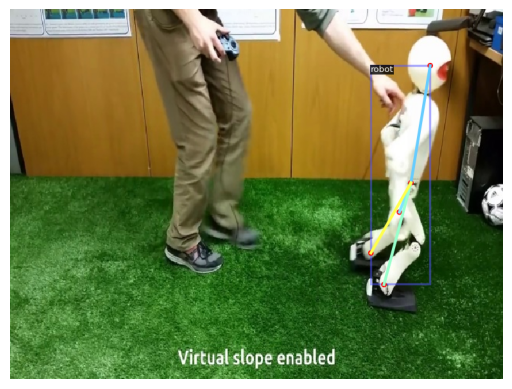

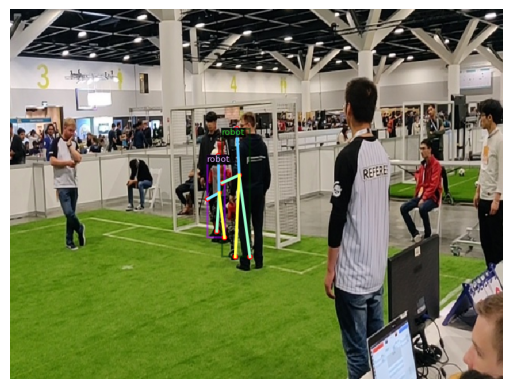

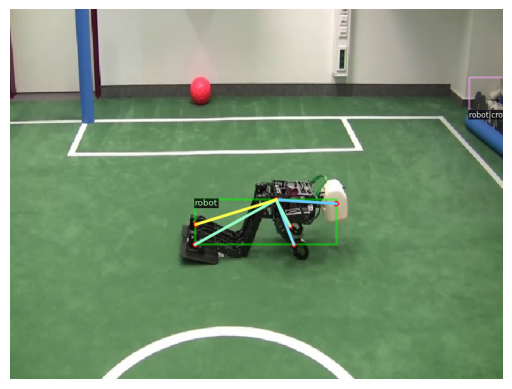

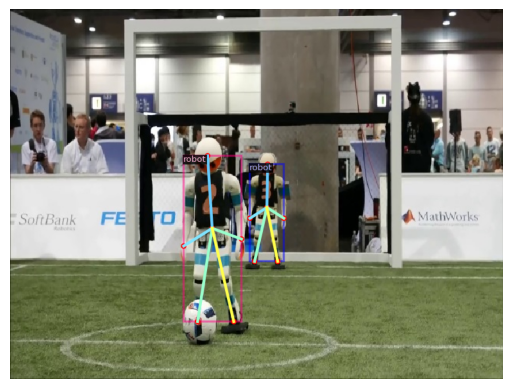

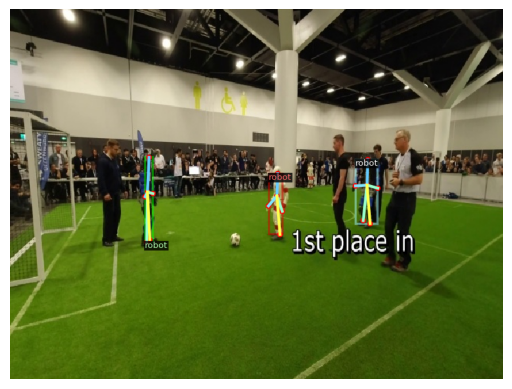

In [11]:
    
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=robots_metadata, scale=1.2)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image())

# Training

In [11]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("robots_train",)


cfg.DATASETS.TEST = ("robots_test",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # robot
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((6, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)

if cfg.TEST.AUG.ENABLED:
  trainer.register_hooks(
    [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]   #this block uses a hook to run evalutaion periodically
  )           

trainer.train()


[11/07 18:48:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/07 18:48:51 d2.data.datasets.coco]: Loaded 1004 images in COCO format from dataset/robot_keypoints_train_fixed.json
[11/07 18:48:51 d2.data.build]: Removed 0 images with no usable annotations. 1004 images left.
[11/07 18:48:51 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[11/07 18:48:51 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   robot    | 1668         |
|            |              |
[11/07 18:48:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/07 18:48:52 d2.data.build]: Using training sampler TrainingSampler
[11/07 18:48:52 d2.data.common]: Serializing 1004 elements to byte tensors and concatenating them all ...
[11/07 18:48:52 d2.data.common]: Serialized dataset takes 0.48 MiB
WARNING [11/07 18:48:52 d2.solver.build]: SOLVER.

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 6, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[11/07 18:48:54 d2.engine.train_loop]: Starting training from iteration 0


/home/reza/env/lib/python3.8/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/home/reza/env/lib/python3.8/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/home/reza/env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future

[11/07 18:49:20 d2.utils.events]:  eta: 0:39:35  iter: 19  total_loss: 8.982  loss_cls: 0.4166  loss_box_reg: 0.2364  loss_keypoint: 8.085  loss_rpn_cls: 0.08813  loss_rpn_loc: 0.05838  time: 1.2206  data_time: 0.0344  lr: 4.9953e-06  max_mem: 2516M
[11/07 18:49:44 d2.utils.events]:  eta: 0:39:27  iter: 39  total_loss: 8.851  loss_cls: 0.3464  loss_box_reg: 0.2025  loss_keypoint: 8.062  loss_rpn_cls: 0.1076  loss_rpn_loc: 0.06337  time: 1.2238  data_time: 0.0096  lr: 9.9902e-06  max_mem: 2516M
[11/07 18:50:09 d2.utils.events]:  eta: 0:39:21  iter: 59  total_loss: 8.782  loss_cls: 0.3315  loss_box_reg: 0.2507  loss_keypoint: 8.059  loss_rpn_cls: 0.06117  loss_rpn_loc: 0.04002  time: 1.2283  data_time: 0.0095  lr: 1.4985e-05  max_mem: 2516M
[11/07 18:50:34 d2.utils.events]:  eta: 0:39:05  iter: 79  total_loss: 8.877  loss_cls: 0.3753  loss_box_reg: 0.2606  loss_keypoint: 8.047  loss_rpn_cls: 0.04638  loss_rpn_loc: 0.06357  time: 1.2362  data_time: 0.0094  lr: 1.998e-05  max_mem: 2516M
[1

[11/07 19:03:36 d2.utils.events]:  eta: 0:28:36  iter: 679  total_loss: 5.484  loss_cls: 0.1116  loss_box_reg: 0.1838  loss_keypoint: 5.073  loss_rpn_cls: 0.03071  loss_rpn_loc: 0.0421  time: 1.2881  data_time: 0.0095  lr: 0.00016983  max_mem: 2516M
[11/07 19:04:03 d2.utils.events]:  eta: 0:28:11  iter: 699  total_loss: 5.288  loss_cls: 0.07594  loss_box_reg: 0.1567  loss_keypoint: 4.975  loss_rpn_cls: 0.02318  loss_rpn_loc: 0.02089  time: 1.2891  data_time: 0.0095  lr: 0.00017483  max_mem: 2516M
[11/07 19:04:29 d2.utils.events]:  eta: 0:27:46  iter: 719  total_loss: 5.326  loss_cls: 0.08649  loss_box_reg: 0.135  loss_keypoint: 4.783  loss_rpn_cls: 0.04351  loss_rpn_loc: 0.03783  time: 1.2894  data_time: 0.0099  lr: 0.00017982  max_mem: 2516M
[11/07 19:04:55 d2.utils.events]:  eta: 0:27:19  iter: 739  total_loss: 5.34  loss_cls: 0.07771  loss_box_reg: 0.1674  loss_keypoint: 4.914  loss_rpn_cls: 0.03215  loss_rpn_loc: 0.04099  time: 1.2886  data_time: 0.0111  lr: 0.00018482  max_mem: 25

[11/07 19:18:18 d2.utils.events]:  eta: 0:14:38  iter: 1339  total_loss: 4.911  loss_cls: 0.06964  loss_box_reg: 0.1529  loss_keypoint: 4.62  loss_rpn_cls: 0.009248  loss_rpn_loc: 0.02887  time: 1.3067  data_time: 0.0099  lr: 0.00025  max_mem: 2516M
[11/07 19:18:46 d2.utils.events]:  eta: 0:14:13  iter: 1359  total_loss: 4.596  loss_cls: 0.08728  loss_box_reg: 0.1706  loss_keypoint: 4.248  loss_rpn_cls: 0.02009  loss_rpn_loc: 0.03903  time: 1.3075  data_time: 0.0108  lr: 0.00025  max_mem: 2516M
[11/07 19:19:13 d2.utils.events]:  eta: 0:13:47  iter: 1379  total_loss: 4.989  loss_cls: 0.07055  loss_box_reg: 0.149  loss_keypoint: 4.67  loss_rpn_cls: 0.008669  loss_rpn_loc: 0.03957  time: 1.3081  data_time: 0.0111  lr: 0.00025  max_mem: 2516M
[11/07 19:19:39 d2.utils.events]:  eta: 0:13:20  iter: 1399  total_loss: 4.57  loss_cls: 0.05583  loss_box_reg: 0.117  loss_keypoint: 4.329  loss_rpn_cls: 0.01513  loss_rpn_loc: 0.0347  time: 1.3085  data_time: 0.0102  lr: 0.00025  max_mem: 2516M
[11/

[11/07 19:33:12 d2.utils.events]:  eta: 0:00:00  iter: 1999  total_loss: 4.52  loss_cls: 0.06507  loss_box_reg: 0.1279  loss_keypoint: 4.286  loss_rpn_cls: 0.01309  loss_rpn_loc: 0.03825  time: 1.3196  data_time: 0.0103  lr: 0.00025  max_mem: 2516M
[11/07 19:33:12 d2.engine.hooks]: Overall training speed: 1998 iterations in 0:43:56 (1.3197 s / it)
[11/07 19:33:12 d2.engine.hooks]: Total training time: 0:44:14 (0:00:17 on hooks)
[11/07 19:33:12 d2.data.datasets.coco]: Loaded 466 images in COCO format from dataset/robot_keypoints_test_fixed.json
[11/07 19:33:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   robot    | 727          |
|            |              |
[11/07 19:33:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/07 19:33:12 d2.data.common]: Serializing 466 elements to byte ten

In [13]:
# Save custom config
with open("keypoint_robot.yaml", "w") as f: 
    f.write(cfg.dump())

# Test

In [1]:
import os
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()
cfg.merge_from_file("keypoint_robot.yaml")

# load the pre trained model from Detectron2 model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [2]:
from detectron2.utils.visualizer import ColorMode

In [3]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');


predictor = DefaultPredictor(cfg)

In [4]:
im = cv2.imread("dataset/images/0019.jpg")
outputs = predictor(im)
# print(outputs)
# o = outputs["instances"]
# print("###########################################################")

/home/reza/env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/reza/env/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/reza/env/lib/python3.8/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future ve

In [8]:
outputs["instances"].pred_keypoints

tensor([[[3.5698e+02, 1.0839e+02, 4.3518e-01],
         [3.4919e+02, 2.3429e+02, 8.6596e-01],
         [2.7194e+02, 1.5755e+02, 2.1893e-01],
         [4.5639e+02, 1.6714e+02, 4.5112e-01],
         [2.9170e+02, 2.7985e+02, 1.6502e-01],
         [3.3302e+02, 3.6738e+02, 3.3813e-01]]], device='cuda:0')

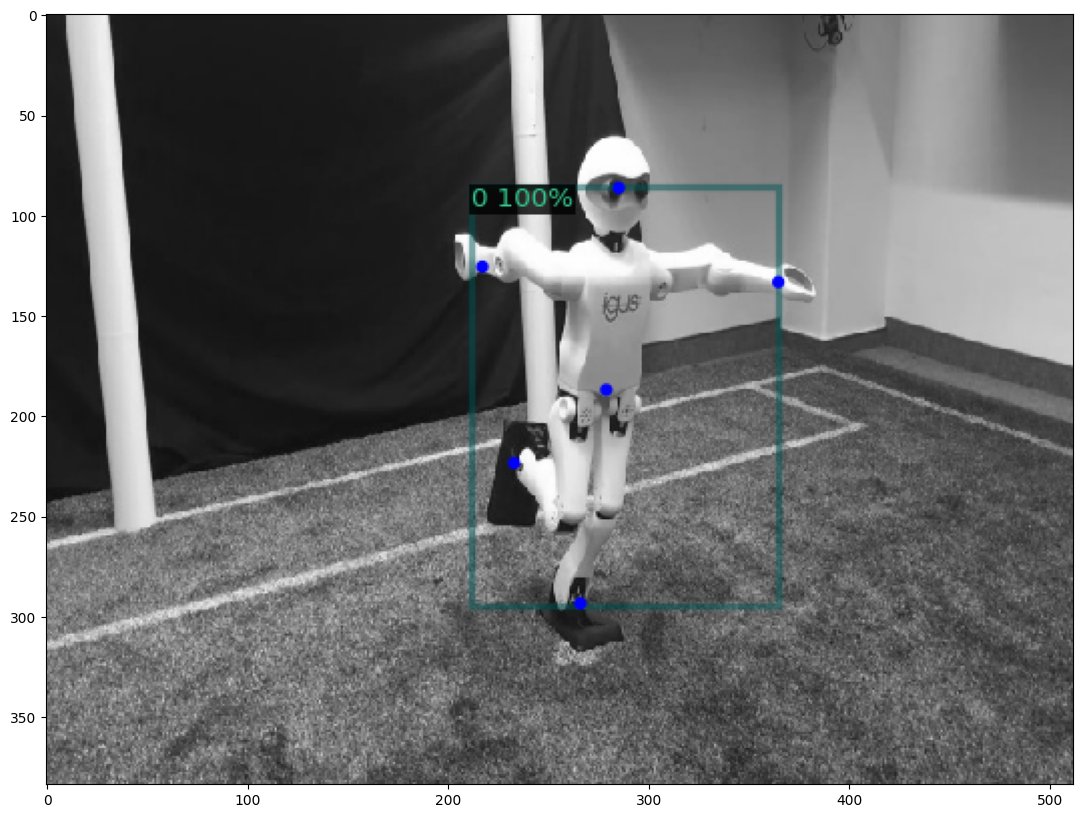

In [5]:
v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
               
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [1]:
import json
import pydash

In [2]:
train = data = json.load(open('dataset/robot_keypoints_test.json'))

In [3]:
bbox = pydash.map_(train['annotations'], 'bbox')

In [4]:
annotations = train['annotations']

In [5]:
annotations

[{'segmentation': [],
  'num_keypoints': 6,
  'area': 2628.0,
  'iscrowd': 0,
  'keypoints': [437,
   221,
   1,
   439,
   285,
   1,
   433,
   298,
   1,
   436,
   310,
   1,
   451,
   364,
   1,
   443,
   367,
   1],
  'image_id': 1478,
  'bbox': [433.6, 221.0, 146.0, 18.0],
  'category_id': 1,
  'id': 1},
 {'segmentation': [],
  'num_keypoints': 6,
  'area': 7650.0,
  'iscrowd': 0,
  'keypoints': [251,
   173,
   1,
   250,
   232,
   1,
   229,
   248,
   1,
   274,
   245,
   1,
   240,
   343,
   1,
   261,
   342,
   1],
  'image_id': 1478,
  'bbox': [229.0, 173.0, 170.0, 45.0],
  'category_id': 1,
  'id': 2},
 {'segmentation': [],
  'num_keypoints': 6,
  'area': 3432.0,
  'iscrowd': 0,
  'keypoints': [210,
   96,
   1,
   217,
   154,
   1,
   211,
   171,
   1,
   220,
   187,
   1,
   223,
   235,
   1,
   234,
   239,
   1],
  'image_id': 1479,
  'bbox': [210.0, 96.0, 143.0, 24.0],
  'category_id': 1,
  'id': 3},
 {'segmentation': [],
  'num_keypoints': 5,
  'area': 527

In [6]:
bbox

[[433.6, 221.0, 146.0, 18.0],
 [229.0, 173.0, 170.0, 45.0],
 [210.0, 96.0, 143.0, 24.0],
 [3.0, 54.0, 203.0, 26.0],
 [360.27, 208.0, 142.0, 36.0],
 [150.0, 166.0, 175.0, 52.0],
 [333.3, 156.0, 136.0, 42.0],
 [279.0, 126.0, 139.0, 39.0],
 [102.0, 129.0, 340.0, 29.0],
 [170.0, 151.0, 67.0, 16.0],
 [219.0, 175.0, 21.0, 8.0],
 [326.0, 141.0, 138.0, 39.0],
 [382.0, 172.0, 139.0, 41.0],
 [134.0, 341.0, 67.0, 139.0],
 [357.32, 170.0, 136.0, 42.0],
 [302.0, 140.0, 137.0, 40.0],
 [202.0, 189.0, 46.0, 11.0],
 [119.0, 303.0, 53.0, 177.0],
 [192.0, 190.0, 61.0, 16.0],
 [280.0, 154.0, 142.0, 44.0],
 [347.38, 187.0, 136.0, 44.0],
 [130.0, 349.0, 38.0, 131.0],
 [255.0, 224.0, 97.0, 26.0],
 [281.13, 193.0, 178.0, 54.0],
 [143.0, 365.0, 40.0, 115.0],
 [527.0, 84.0, 75.0, 19.0],
 [318.0, 82.0, 201.0, 51.0],
 [277.0, 158.0, 58.0, 11.0],
 [210.0, 296.44, 91.0, 66.0],
 [43.4, 185.0, 284.0, 60.0],
 [528.0, 101.0, 67.0, 19.0],
 [316.0, 94.0, 189.0, 49.0],
 [276.0, 168.0, 55.0, 12.0],
 [236.0, 159.0, 225.0, 3

In [7]:
def fix_bbox(box):
    x, y, h, w = box
    
    return [x, y, w, h]

bbox_fixed = pydash.map_(bbox, lambda x: fix_bbox(x))

In [8]:
for anot, bbx in zip(train['annotations'], bbox_fixed):
    anot['bbox'] = bbx

In [9]:
train['annotations']

[{'segmentation': [],
  'num_keypoints': 6,
  'area': 2628.0,
  'iscrowd': 0,
  'keypoints': [437,
   221,
   1,
   439,
   285,
   1,
   433,
   298,
   1,
   436,
   310,
   1,
   451,
   364,
   1,
   443,
   367,
   1],
  'image_id': 1478,
  'bbox': [433.6, 221.0, 18.0, 146.0],
  'category_id': 1,
  'id': 1},
 {'segmentation': [],
  'num_keypoints': 6,
  'area': 7650.0,
  'iscrowd': 0,
  'keypoints': [251,
   173,
   1,
   250,
   232,
   1,
   229,
   248,
   1,
   274,
   245,
   1,
   240,
   343,
   1,
   261,
   342,
   1],
  'image_id': 1478,
  'bbox': [229.0, 173.0, 45.0, 170.0],
  'category_id': 1,
  'id': 2},
 {'segmentation': [],
  'num_keypoints': 6,
  'area': 3432.0,
  'iscrowd': 0,
  'keypoints': [210,
   96,
   1,
   217,
   154,
   1,
   211,
   171,
   1,
   220,
   187,
   1,
   223,
   235,
   1,
   234,
   239,
   1],
  'image_id': 1479,
  'bbox': [210.0, 96.0, 24.0, 143.0],
  'category_id': 1,
  'id': 3},
 {'segmentation': [],
  'num_keypoints': 5,
  'area': 527

In [10]:
# Serializing json
json_object = json.dumps(train, indent=4)
 
# Writing to sample.json
with open("dataset/robot_keypoints_test_fixed.json", "w") as outfile:
    outfile.write(json_object)